<a href="https://colab.research.google.com/github/renjithsasidharan/JSON-Airlines/blob/master/transformer_combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip ./drive/My\ Drive/training_data/er_transformer/training_14_as_12_seq_nums.zip
!cp -r ./training_14_as_12_seq_nums/* ./

Archive:  ./drive/My Drive/training_data/er_transformer/training_14_as_12_seq_nums.zip
   creating: training_14_as_12_seq_nums/
  inflating: training_14_as_12_seq_nums/transformer_dates.py  
  inflating: training_14_as_12_seq_nums/eval.tsv  
  inflating: training_14_as_12_seq_nums/ocr_text.py  
  inflating: training_14_as_12_seq_nums/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/training_14_as_12_seq_nums/
  inflating: __MACOSX/training_14_as_12_seq_nums/._.DS_Store  
  inflating: training_14_as_12_seq_nums/train.tsv.ocr.subwords  
  inflating: training_14_as_12_seq_nums/transformer_dates.ipynb  
  inflating: training_14_as_12_seq_nums/create_eval_data.py  
  inflating: __MACOSX/training_14_as_12_seq_nums/._create_eval_data.py  
  inflating: training_14_as_12_seq_nums/train.tsv  
  inflating: training_14_as_12_seq_nums/create_training_data_test.py  
  inflating: training_14_as_12_seq_nums/config.json  
  inflating: training_14_as_12_seq_nums/augmentation.py  
  inflating: __

In [0]:
!rm -rf ./checkpoints/train/*

In [5]:
!pip install -q pyonmttok

     |████████████████████████████████| 2.2MB 4.9MB/s 


# Transformer model for language understanding

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

import json
import time
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pyonmttok
import pandas as pd


In [8]:
print(tf.__version__)

2.2.0


## Setup input pipeline

In [0]:
train_file_path='./train.tsv'
test_file_path='./test.tsv'

In [0]:
def load_currency_classes():
    with open('currency_classes.json') as f:
        currency_classes = json.load(f)
    return currency_classes

def load_country_classes():
    with open('country_classes.json') as f:
        country_classes = json.load(f)
    return country_classes


def encode_label(label, classes):
    label_encoded = np.zeros(len(classes))
    label_encoded[classes.index(label)] = 1
    return label_encoded

In [0]:
def preprocess(x):
    t, _ = tokenizer_pre.tokenize(x)
    return " ".join(t)

tokenizer_pre = pyonmttok.Tokenizer("aggressive", joiner_annotate=True, segment_numbers=True)

In [0]:

currency_classes = load_currency_classes()
country_classes = load_country_classes()

training_df = pd.read_csv(train_file_path,
                          sep='\t',
                          float_precision='round_trip',
                          dtype={'amount': str,
                                 'date': str,
                                 'country': str,
                                 'currency': str,
                                 'ocr_text': object})

testing_df = pd.read_csv(test_file_path,
                          sep='\t',
                          dtype={'amount': str,
                                 'date': str,
                                 'country': str,
                                 'currency': str,
                                 'ocr_text': object})

training_df["ocr_text"] = training_df["ocr_text"].apply(lambda x: x.lower())
testing_df["ocr_text"] = testing_df["ocr_text"].apply(lambda x: x.lower())

training_df["ocr_text"] = training_df["ocr_text"].apply(lambda x: preprocess(x))
training_df["amount"] = training_df["amount"].apply(lambda x: preprocess(x))
training_df["date"] = training_df["date"].apply(lambda x: preprocess(x))
testing_df["ocr_text"] = testing_df["ocr_text"].apply(lambda x: preprocess(x))
testing_df["amount"] = testing_df["amount"].apply(lambda x: preprocess(x))
testing_df["date"] = testing_df["date"].apply(lambda x: preprocess(x))

training_examples = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_df['ocr_text'].values, tf.string),
            tf.cast(training_df['amount'].values, tf.string),
            tf.cast(training_df['date'].values, tf.string),
            tf.cast(training_df['country'].apply(lambda x: country_classes.index(x)).values, tf.int32)
        )
    )
)


val_examples = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_df['ocr_text'].values, tf.string),
            tf.cast(testing_df['amount'].values, tf.string),
            tf.cast(testing_df['date'].values, tf.string),
            tf.cast(testing_df['country'].apply(lambda x: country_classes.index(x)).values, tf.int32)
        )
    )
)


In [0]:
NUM_COUNTRY_CLASSES = len(country_classes)
NUM_CURRENCY_CLASSES = len(currency_classes)

Create a custom subwords tokenizer from the training dataset. 

In [16]:
print("{}.ocr.subwords".format(train_file_path))
if os.path.isfile("{}.ocr.subwords".format(train_file_path)):
  print('Loading input tokenizer from disk')
  tokenizer_ocr = tfds.features.text.SubwordTextEncoder.load_from_file(train_file_path + ".ocr")
else:
  print('Creating new tokenizer from training set')
  tokenizer_ocr = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (ocr.numpy() for ocr, _, _, _ in training_examples), target_vocab_size=2**13)
  tokenizer_ocr.save_to_file(train_file_path + ".ocr")
print(tokenizer_ocr.vocab_size)

./train.tsv.ocr.subwords
Loading input tokenizer from disk
32835


In [0]:
tokenizer_date = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (date.numpy() for _, _, date, _ in training_examples), target_vocab_size=2**9)
tokenizer_date.save_to_file(train_file_path + ".date")

In [0]:
tokenizer_amount = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (amount.numpy() for _, amount, _, _ in training_examples), target_vocab_size=2**9)
tokenizer_amount.save_to_file(train_file_path + ".amount")

In [0]:
tokenizer_amount = tokenizer_ocr

In [20]:
date_str = "13/11/2019"
print('Original date {}'.format(date_str))
print('Tokenized date {}'.format(tokenizer_date.encode(date_str)))
print('Tokens {}'.format([tokenizer_date.decode([x]) for x in tokenizer_date.encode(date_str)]))

Original date 13/11/2019
Tokenized date [52, 54, 50, 52, 52, 50, 53, 51, 52, 60]
Tokens ['1', '3', '/', '1', '1', '/', '2', '0', '1', '9']


In [21]:
amount_str = "2185.90"
print('Original amount {}'.format(amount_str))
print('Tokenized amount {}'.format(tokenizer_amount.encode(amount_str)))
print('Tokens {}'.format([tokenizer_amount.decode([x]) for x in tokenizer_amount.encode(amount_str)]))

Original amount 2185.90
Tokenized amount [32629, 32628, 32635, 32632, 32625, 32636, 32627]
Tokens ['2', '1', '8', '5', '.', '9', '0']


In [22]:
sample_string = 'The target date is 13.11.2019 and amount is 199.55'

tokenized_string = tokenizer_ocr.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_ocr.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

print('Tokens {}'.format([tokenizer_ocr.decode([x]) for x in tokenizer_ocr.encode(original_string)]))

assert original_string == sample_string

Tokenized string is [32663, 1102, 20511, 93, 94, 233, 32628, 32630, 32625, 32628, 32628, 32625, 32629, 32627, 32628, 14, 209, 219, 233, 32628, 32636, 32636, 32625, 32632, 32632]
The original string: The target date is 13.11.2019 and amount is 199.55
Tokens ['T', 'he ', 'targ', 'et ', 'date ', 'is ', '1', '3', '.', '1', '1', '.', '2', '0', '1', '9 ', 'and ', 'amount ', 'is ', '1', '9', '9', '.', '5', '5']


In [23]:
print(tokenizer_amount.vocab_size)
print(tokenizer_date.vocab_size)
print(tokenizer_ocr.vocab_size)

32835
259
32835


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [24]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_ocr.decode([ts])))

32663 ----> T
1102 ----> he 
20511 ----> targ
93 ----> et 
94 ----> date 
233 ----> is 
32628 ----> 1
32630 ----> 3
32625 ----> .
32628 ----> 1
32628 ----> 1
32625 ----> .
32629 ----> 2
32627 ----> 0
32628 ----> 1
14 ----> 9 
209 ----> and 
219 ----> amount 
233 ----> is 
32628 ----> 1
32636 ----> 9
32636 ----> 9
32625 ----> .
32632 ----> 5
32632 ----> 5


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [0]:
def encode(ocr_param, amount_param, date_param, country_param, num_country_classes):
  ocr = [tokenizer_ocr.vocab_size] + tokenizer_ocr.encode(
      ocr_param.numpy()) + [tokenizer_ocr.vocab_size+1]

  date = [tokenizer_date.vocab_size] + tokenizer_date.encode(
      date_param.numpy()) + [tokenizer_date.vocab_size+1]
    
  amount = [tokenizer_amount.vocab_size] + tokenizer_amount.encode(
      amount_param.numpy()) + [tokenizer_amount.vocab_size+1]
    
  country = tf.one_hot(country_param, num_country_classes)
  
  return ocr, amount, date, country

Note: To keep this example small and relatively fast, drop examples with a length of over 40 tokens.

In [0]:
MAX_LENGTH = 800

In [0]:
def filter_max_length(x, y1, y2, y3, max_length=MAX_LENGTH):
  return tf.logical_and(tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y1) <= max_length), tf.size(y2) <= max_length)

Operations inside `.map()` run in graph mode and receive a graph tensor that do not have a numpy attribute. The `tokenizer` expects a string or Unicode symbol to encode it into integers. Hence, you need to run the encoding inside a `tf.py_function`, which receives an eager tensor having a numpy attribute that contains the string value.

In [0]:
def tf_encode(ocr, amount, date, country):
  num_country_classes = len(country_classes)  
  return tf.py_function(encode,
                        [ocr, amount, date, country, num_country_classes],
                        [tf.int64, tf.int64, tf.int64, tf.float32])

In [30]:
training_examples

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.int32)>

In [0]:
train_dataset = training_examples \
                .map(tf_encode) \
                .filter(filter_max_length) \
                .cache() \
                .shuffle(BUFFER_SIZE) \
                .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1], [-1], [-1])) \
                .prefetch(tf.data.experimental.AUTOTUNE) \

valid_dataset = val_examples \
                .map(tf_encode) \
                .filter(filter_max_length) \
                .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1], [-1], [-1]))

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


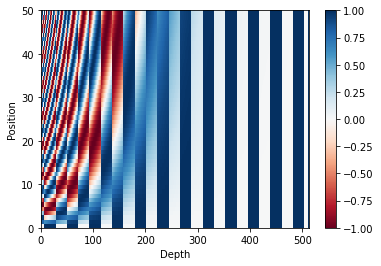

In [34]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [36]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [38]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [41]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [42]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [43]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [44]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [46]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [48]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [50]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [52]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [54]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)

    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [56]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### Classifier

In [0]:
class Classifier(tf.keras.layers.Layer):
  def __init__(self, name, num_classes, num_hidden_layers=128, rate=0.1):
    super(Classifier, self).__init__()

    self.pooling = tf.keras.layers.GlobalAveragePooling1D()
    self.dropout = tf.keras.layers.Dropout(rate)
    self.hidden_layer = tf.keras.layers.Dense(num_hidden_layers, activation="relu")
    self.final_layer = tf.keras.layers.Dense(num_classes, name=name, activation="softmax")

  def call(self, enc_output, training):
    x = self.pooling(enc_output)
    x = self.dropout(x, training=training)
    x = self.hidden_layer(x)
    y = self.final_layer(x)

    return y

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self,
               num_layers,
               d_model,
               num_heads,
               dff,
               input_vocab_size, 
               target_vocab_size_dt,
               target_vocab_size_amt,
               pe_input,
               pe_target_dt,
               pe_target_amt,
               num_country_classes,
               rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder_dt = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size_dt, pe_target_dt, rate)
    
    self.decoder_amt = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size_amt, pe_target_amt, rate)
    
    self.country_classifier = Classifier(name="country_classifier", num_classes=num_country_classes)

    self.final_layer_dt = tf.keras.layers.Dense(target_vocab_size_dt)
    self.final_layer_amt = tf.keras.layers.Dense(target_vocab_size_amt)
    
  def call(self,
           inp,
           tar_dt,
           tar_amt,
           training,
           enc_padding_mask, 
           look_ahead_mask_dt,
           look_ahead_mask_amt,
           dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output_dt, attention_weights_dt = self.decoder_dt(
        tar_dt, enc_output, training, look_ahead_mask_dt, dec_padding_mask)
    
    dec_output_amt, attention_weights_amt = self.decoder_amt(
        tar_amt, enc_output, training, look_ahead_mask_amt, dec_padding_mask)
    
    final_output_dt = self.final_layer_dt(dec_output_dt)  # (batch_size, tar_seq_len, target_vocab_size)
    final_output_amt = self.final_layer_amt(dec_output_amt)
    final_output_country = self.country_classifier(enc_output, training)    
    
    return final_output_dt, attention_weights_dt, final_output_amt, attention_weights_amt, final_output_country

In [59]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500,
    target_vocab_size_dt=2000,
    target_vocab_size_amt=8500, 
    pe_input=10000,
    pe_target_dt=6000,
    pe_target_amt=6000,
    num_country_classes=150)

temp_input = tf.random.uniform((64, 62))
temp_target_dt = tf.random.uniform((64, 26))
temp_target_amt = tf.random.uniform((64, 32))

fn_out_dt, _, fn_out_amt, _,  fn_out_country  = sample_transformer(temp_input,
                                                                   temp_target_dt,
                                                                   temp_target_amt,
                                                                   training=False, 
                                                                   enc_padding_mask=None, 
                                                                   look_ahead_mask_dt=None,
                                                                   look_ahead_mask_amt=None,
                                                                   dec_padding_mask=None)

print(fn_out_dt.shape)  # (batch_size, tar_seq_len, target_vocab_size)
print(fn_out_amt.shape)
print(fn_out_country.shape)

(64, 26, 2000)
(64, 32, 8500)
(64, 150)


## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [0]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 4

input_vocab_size = tokenizer_ocr.vocab_size + 2
target_vocab_size_dt = tokenizer_date.vocab_size + 2
target_vocab_size_amt = tokenizer_amount.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

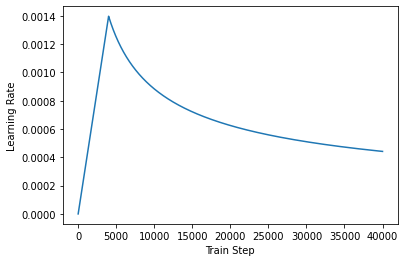

In [63]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [0]:
loss_object_seq = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

loss_object_classifier = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction='none')

In [0]:
def loss_function_seq(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object_seq(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

def loss_function_classifier(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object_classifier(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  
  return tf.reduce_mean(loss_)

In [0]:
train_loss_dt = tf.keras.metrics.Mean(name='train_loss_dt')
train_loss_amt = tf.keras.metrics.Mean(name='train_loss_amt')
train_loss_country = tf.keras.metrics.Mean(name='train_loss_country')
train_accuracy_dt = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy_dt')
train_accuracy_amt = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy_amt')
train_accuracy_country = tf.keras.metrics.CategoricalAccuracy(
    name='train_accuracy_country')

valid_loss_dt = tf.keras.metrics.Mean(name='valid_loss_dt')
valid_loss_amt = tf.keras.metrics.Mean(name='valid_loss_amt')
valid_loss_country = tf.keras.metrics.Mean(name='valid_loss_country')
valid_accuracy_dt = tf.keras.metrics.SparseCategoricalAccuracy(
    name='valid_accuracy_dt')
valid_accuracy_amt = tf.keras.metrics.SparseCategoricalAccuracy(
    name='valid_accuracy_amt')
valid_accuracy_country = tf.keras.metrics.CategoricalAccuracy(
    name='valid_accuracy_country')

## Training and checkpointing

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size,
                          target_vocab_size_dt,
                          target_vocab_size_amt,
                          pe_input=input_vocab_size, 
                          pe_target_dt=target_vocab_size_dt,
                          pe_target_amt=target_vocab_size_amt,
                          num_country_classes=len(country_classes),
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar_dt, tar_amt):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask_dt = create_look_ahead_mask(tf.shape(tar_dt)[1])
  dec_target_padding_mask_dt = create_padding_mask(tar_dt)
  combined_mask_dt = tf.maximum(dec_target_padding_mask_dt, look_ahead_mask_dt)

  look_ahead_mask_amt = create_look_ahead_mask(tf.shape(tar_amt)[1])
  dec_target_padding_mask_amt = create_padding_mask(tar_amt)
  combined_mask_amt = tf.maximum(dec_target_padding_mask_amt, look_ahead_mask_amt)
  
  return enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [0]:
EPOCHS = 10

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar_dt, tar_amt, tar_country):
  tar_inp_dt = tar_dt[:, :-1]
  tar_real_dt = tar_dt[:, 1:]
  tar_inp_amt = tar_amt[:, :-1]
  tar_real_amt = tar_amt[:, 1:]
  
  enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt = create_masks(inp, tar_inp_dt, tar_inp_amt)

  with tf.GradientTape() as tape:
    predictions_dt, _, predictions_amt, _, predictions_country = transformer(inp,
                                                                             tar_inp_dt,
                                                                             tar_inp_amt,
                                                                             True, 
                                                                             enc_padding_mask, 
                                                                             combined_mask_dt,
                                                                             combined_mask_amt,
                                                                             dec_padding_mask)
    loss_dt = loss_function_seq(tar_real_dt, predictions_dt)
    loss_amt = loss_function_seq(tar_real_amt, predictions_amt)
    loss_country = loss_function_classifier(tar_country, predictions_country)
    loss = loss_dt + loss_amt + loss_country

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss_dt(loss_dt)
  train_loss_amt(loss_amt)
  train_loss_country(loss_country)
  train_accuracy_dt(tar_real_dt, predictions_dt)
  train_accuracy_amt(tar_real_amt, predictions_amt)
  train_accuracy_country(tar_country, predictions_country)

@tf.function(input_signature=train_step_signature)
def valid_epoch(inp, tar_dt, tar_amt, tar_country):
  tar_inp_dt = tar_dt[:, :-1]
  tar_real_dt = tar_dt[:, 1:]
  tar_inp_amt = tar_amt[:, :-1]
  tar_real_amt = tar_amt[:, 1:]
  
  enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt = create_masks(inp,
                                                                                         tar_inp_dt,
                                                                                         tar_inp_amt)
  
  predictions_dt, _, predictions_amt, _, predictions_country = transformer(inp, 
                                                                           tar_inp_dt,
                                                                           tar_inp_amt, 
                                                                           False, 
                                                                           enc_padding_mask, 
                                                                           combined_mask_dt,
                                                                           combined_mask_amt, 
                                                                           dec_padding_mask)
  loss_dt = loss_function_seq(tar_real_dt, predictions_dt)
  loss_amt = loss_function_seq(tar_real_amt, predictions_amt)
  loss_country = loss_function_classifier(tar_country, predictions_country)
  
  valid_loss_dt(loss_dt)
  valid_loss_amt(loss_amt)
  valid_loss_country(loss_country)
  valid_accuracy_dt(tar_real_dt, predictions_dt)
  valid_accuracy_amt(tar_real_amt, predictions_amt)
  valid_accuracy_country(tar_country, predictions_country)

Ocr text is used as the input language and amount is the target language.

In [72]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss_dt.reset_states()
  train_accuracy_dt.reset_states()
  train_loss_amt.reset_states()
  train_accuracy_amt.reset_states()
  train_loss_country.reset_states()
  train_accuracy_country.reset_states()

  valid_loss_dt.reset_states()
  valid_accuracy_dt.reset_states()
  valid_loss_amt.reset_states()
  valid_accuracy_amt.reset_states()
  valid_loss_country.reset_states()
  valid_accuracy_country.reset_states()
  
  # inp -> ocr, tar -> amount, date, country
  for (batch, (inp, tar_amt , tar_dt, tar_country)) in enumerate(train_dataset):
    train_step(inp, tar_dt, tar_amt, tar_country)
    
    if batch % 100 == 0:
      print ("""Epoch {} Batch {}  Training Loss Date {:.4f} Training Loss Amount {:.4f} Training Loss Country {:.4f} Accuracy Date {:.4f} Accuracy Amount {:.4f} Accuracy Country {:.4f}"""
             .format(epoch + 1,
                      batch,
                      train_loss_dt.result(),
                      train_loss_amt.result(),
                      train_loss_country.result(),
                      train_accuracy_dt.result(),
                      train_accuracy_amt.result(),
                      train_accuracy_country.result()))
      
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ("""Epoch {} Training Loss Date {:.4f} Training Loss Amount {:.4f} Training Loss Country {:.4f} Accuracy Date {:.4f} Accuracy Amount {:.4f} Accuracy Country {:.4f}"""
         .format(epoch + 1, 
                train_loss_dt.result(), 
                train_loss_amt.result(), 
                train_loss_country.result(),
                train_accuracy_dt.result(),
                train_accuracy_amt.result(),
                train_accuracy_country.result()))
  
  for (batch, (inp, tar_amt, tar_dt, tar_country)) in enumerate(valid_dataset):
    valid_epoch(inp, tar_dt, tar_amt, tar_country)

  print ("""Epoch {} Validation Loss Date {:.4f} Validation Loss Amount {:.4f} Validation Loss Country {:.4f} Accuracy Date {:.4f} Accuracy Amount {:.4f} Accuracy Country {:.4f}"""
            .format(epoch + 1, 
                    valid_loss_dt.result(), 
                    valid_loss_amt.result(), 
                    valid_loss_country.result(), 
                    valid_accuracy_dt.result(),
                    valid_accuracy_amt.result(),
                    valid_accuracy_country.result()))

  print ('Time taken for 1 epoch: {:.2f} secs\n'.format(time.time() - start))

Epoch 1 Batch 0  Training Loss Date 5.8738 Training Loss Amount 4.6624 Training Loss Country 5.4792 Accuracy Date 0.0029 Accuracy Amount 0.0000 Accuracy Country 0.0156
Epoch 1 Batch 100  Training Loss Date 4.5900 Training Loss Amount 6.4253 Training Loss Country 4.6579 Accuracy Date 0.1526 Accuracy Amount 0.0433 Accuracy Country 0.1638
Epoch 1 Batch 200  Training Loss Date 3.5191 Training Loss Amount 6.1792 Training Loss Country 3.6521 Accuracy Date 0.2950 Accuracy Amount 0.1068 Accuracy Country 0.3060
Epoch 1 Batch 300  Training Loss Date 2.6943 Training Loss Amount 5.6752 Training Loss Country 3.1770 Accuracy Date 0.4414 Accuracy Amount 0.1328 Accuracy Country 0.3589
Epoch 1 Batch 400  Training Loss Date 2.1844 Training Loss Amount 4.9964 Training Loss Country 2.8402 Accuracy Date 0.5266 Accuracy Amount 0.1549 Accuracy Country 0.4154
Epoch 1 Batch 500  Training Loss Date 1.8579 Training Loss Amount 4.3409 Training Loss Country 2.5704 Accuracy Date 0.5787 Accuracy Amount 0.1835 Accura

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the ocr tokenizer (`tokenizer_ocr`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [0]:
def inference_fast(inp_sentence):
  training = False

  start_token = [tokenizer_ocr.vocab_size]
  end_token = [tokenizer_ocr.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ocr.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input_dt = [tokenizer_date.vocab_size]
  output_dt = tf.expand_dims(decoder_input_dt, 0)
    
  decoder_input_amt = [tokenizer_amount.vocab_size]
  output_amt = tf.expand_dims(decoder_input_amt, 0)
  
  enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt = create_masks(
        encoder_input, output_dt, output_amt)

  encoder_out = transformer.encoder(encoder_input, training, enc_padding_mask)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt = create_masks(
        encoder_input, output_dt, output_amt)
    
    dec_output_dt, attention_weights_dt = transformer.decoder_dt(
        output_dt, encoder_out, training, combined_mask_dt, dec_padding_mask)
    
    predictions_dt = transformer.final_layer_dt(dec_output_dt)
    predictions_dt = predictions_dt[: ,-1:, :]  # (batch_size, 1, vocab_size)
    predicted_id_dt = tf.cast(tf.argmax(predictions_dt, axis=-1), tf.int32)
    
    if predicted_id_dt == tokenizer_date.vocab_size+1:
        break
    
    output_dt = tf.concat([output_dt, predicted_id_dt], axis=-1)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt = create_masks(
        encoder_input, output_dt, output_amt)
    
    dec_output_amt, attention_weights_amt = transformer.decoder_amt(
        output_amt, encoder_out, training, combined_mask_amt, dec_padding_mask)
    
    predictions_amt = transformer.final_layer_amt(dec_output_amt)
    predictions_amt = predictions_amt[: ,-1:, :]  # (batch_size, 1, vocab_size)
    predicted_id_amt = tf.cast(tf.argmax(predictions_amt, axis=-1), tf.int32)
    
    if predicted_id_amt == tokenizer_amount.vocab_size+1:
        break
    
    output_amt = tf.concat([output_amt, predicted_id_amt], axis=-1)
    
  predictions_country = transformer.country_classifier(encoder_out, training)
  output_country = tf.squeeze(tf.math.argmax(predictions_country, 1), 0)
    
  return tf.squeeze(output_dt, axis=0), \
         attention_weights_dt, \
         tf.squeeze(output_amt, axis=0), \
         attention_weights_amt, \
         output_country

def inference(inp_sentence):
  start_token = [tokenizer_ocr.vocab_size]
  end_token = [tokenizer_ocr.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ocr.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input_dt = [tokenizer_date.vocab_size]
  output_dt = tf.expand_dims(decoder_input_dt, 0)
  decoder_input_amt = [tokenizer_amount.vocab_size]
  output_amt = tf.expand_dims(decoder_input_amt, 0)
  is_decoded_dt = False
  is_decoded_amt = False
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask_dt, dec_padding_mask, combined_mask_amt = create_masks(
        encoder_input, output_dt, output_amt)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions_dt, \
    attention_weights_dt, \
    predictions_amt, \
    attention_weights_amt, \
    predictions_country = transformer(encoder_input, 
                                      output_dt,
                                      output_amt,
                                      False,
                                      enc_padding_mask,
                                      combined_mask_dt,
                                      combined_mask_amt,
                                      dec_padding_mask)
    
    # select the last word from the seq_len dimension
    if not is_decoded_dt:
      predictions_dt = predictions_dt[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id_dt = tf.cast(tf.argmax(predictions_dt, axis=-1), tf.int32)

    if not is_decoded_amt:
      predictions_amt = predictions_amt[: ,-1:, :]
      predicted_id_amt = tf.cast(tf.argmax(predictions_amt, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id_dt == tokenizer_date.vocab_size+1:
      is_decoded_dt = True
    
    if predicted_id_amt == tokenizer_amount.vocab_size+1:
      is_decoded_amt = True

    if is_decoded_dt and is_decoded_amt:
      return tf.squeeze(output_dt, axis=0), \
       attention_weights_dt, \
       tf.squeeze(output_amt, axis=0), \
       attention_weights_amt, \
       tf.squeeze(tf.math.argmax(predictions_country, 1), 0)
      
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    if not is_decoded_dt:
      output_dt = tf.concat([output_dt, predicted_id_dt], axis=-1)

    if not is_decoded_amt:
      output_amt = tf.concat([output_amt, predicted_id_amt], axis=-1)

  return tf.squeeze(output_dt, axis=0), attention_weights_dt, tf.squeeze(output_amt, axis=0), attention_weights_amt, tf.math.argmax(predictions_country, 1)

In [0]:
def plot_attention_weights(attention, sentence, result, result_tokenizer, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_ocr.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_ocr.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([result_tokenizer.decode([i]) for i in result 
                        if i < result_tokenizer.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(ocr, plot='', log=True):
  enc_result_dt, attention_weights_dt, enc_result_amt, attention_weights_amt, enc_result_country = inference_fast(ocr)
  
  result_dt = tokenizer_date.decode([i for i in enc_result_dt 
                                            if i < tokenizer_date.vocab_size])  
  result_amt = tokenizer_amount.decode([i for i in enc_result_amt 
                                            if i < tokenizer_amount.vocab_size])
  result_country = country_classes[enc_result_country]

  if plot:
    plot_attention_weights(attention_weights_dt, ocr, enc_result_dt,tokenizer_date, plot)
    plot_attention_weights(attention_weights_amt, ocr, enc_result_amt,tokenizer_amount, plot)

  if log:
    print('Input: {}'.format(ocr))
    print('Predicted date: {}'.format(result_dt))
    print('Predicted amount: {}'.format(result_amt))
    print('Predicted country: {}'.format(result_country))
  else:
    return result_dt, result_amt, result_country

In [76]:
translate("* 0KQ8 OK DETALJHANDEL AB ORG NR: 556029-4588 37548 Servogatan 12 SE-19560 TEL NR: 08-59113055  Arlandastad  Belopp 18,00 19,00 37.00 kr 37,00 kr BRUTTO 37,00  Antal  Beskrivning #w#m #W# ■** Aria Kvarg Mild 0,2% 250g Varm Dryck Li ten  1  1  EuroCard:  NETTO MOMS 33,04 3,96  MOMS %  12%  20:30 SEK 37,00  2017-12-18  KOP  EuroCard Butiksnr: 134890 Cal 7 000 SWE 746784 REF.NR :  Termid: 37548122  Personlig kod 375481223988 A0000000041010 0000001000  AID  TVR  6800  TSI  KASSÖRENS NAMN: F, Erik DATUM: 2017-12-18 TRAN: 245569  110:20:30:36 KASSA NR:  2  TACK FOR BESOKET VAEKOMMEN ATER")

Input: * 0KQ8 OK DETALJHANDEL AB ORG NR: 556029-4588 37548 Servogatan 12 SE-19560 TEL NR: 08-59113055  Arlandastad  Belopp 18,00 19,00 37.00 kr 37,00 kr BRUTTO 37,00  Antal  Beskrivning #w#m #W# ■** Aria Kvarg Mild 0,2% 250g Varm Dryck Li ten  1  1  EuroCard:  NETTO MOMS 33,04 3,96  MOMS %  12%  20:30 SEK 37,00  2017-12-18  KOP  EuroCard Butiksnr: 134890 Cal 7 000 SWE 746784 REF.NR :  Termid: 37548122  Personlig kod 375481223988 A0000000041010 0000001000  AID  TVR  6800  TSI  KASSÖRENS NAMN: F, Erik DATUM: 2017-12-18 TRAN: 245569  110:20:30:36 KASSA NR:  2  TACK FOR BESOKET VAEKOMMEN ATER
Predicted date: 2￭ 0￭ 1￭ 8 ￭-￭ 0￭ 7 ￭-￭ 1￭ 2
Predicted amount: 1￭ 0￭ 0 ￭.￭ 0￭ 0
Predicted country: ESP


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65517 missing from current font.
  font.set_text(s, 0, flags=flags)


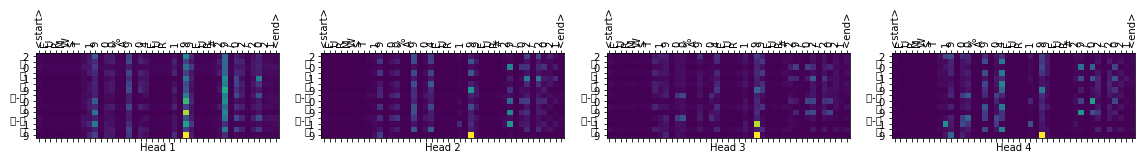

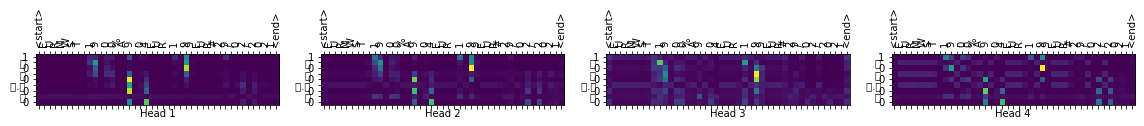

Input: EURMWST 19,00% A9,04 EUR 1,99 EUR# 29/02/2021
Predicted date: 2￭ 0￭ 1￭ 9 ￭-￭ 0￭ 9 ￭-￭ 1￭ 9
Predicted amount: 1￭ 0￭ 0 ￭.￭ 0￭ 0
Predicted country: ESP


In [77]:
translate("EURMWST 19,00% A9,04 EUR 1,99 EUR# 29/02/2021", plot='decoder_layer2_block2')

In [0]:
transformer.save_weights("weights.combo.h5")

In [79]:
!tar -czvf checkpoints.tar.gz checkpoints

checkpoints/
checkpoints/train/
checkpoints/train/ckpt-8.index
checkpoints/train/ckpt-7.index
checkpoints/train/ckpt-6.data-00001-of-00002
checkpoints/train/ckpt-7.data-00001-of-00002
checkpoints/train/ckpt-10.index
checkpoints/train/ckpt-10.data-00000-of-00002
checkpoints/train/ckpt-9.data-00001-of-00002
checkpoints/train/checkpoint
checkpoints/train/ckpt-9.data-00000-of-00002
checkpoints/train/ckpt-8.data-00000-of-00002
checkpoints/train/ckpt-7.data-00000-of-00002
checkpoints/train/ckpt-6.data-00000-of-00002
checkpoints/train/ckpt-6.index
checkpoints/train/ckpt-9.index
checkpoints/train/.DS_Store
checkpoints/train/ckpt-8.data-00001-of-00002
checkpoints/train/ckpt-10.data-00001-of-00002


In [0]:
from tqdm.notebook import tqdm

def eval_dataset(df):
    date_pred = []
    date_gt = []
    amount_pred = []
    amount_gt = []
    country_pred = []
    country_gt = []
    ocr_text = []
    pbar = tqdm(total=df.shape[0])

    for index, row in df.iterrows():
      try:
        date, amount, country = translate(row["ocr_text"], log=False)
      except Exception:
        continue

      date_pred.append(date)
      amount_pred.append(amount)
      country_pred.append(country)
      date_gt.append(row["date"])
      amount_gt.append(row["amount"])
      country_gt.append(row["country"])
      ocr_text.append(row["ocr_text"])

      pbar.update()
        
    df_result = pd.DataFrame()
    df_result["dt_pred"] = date_pred
    df_result["dt_gt"] = date_gt
    df_result["ocr_text"] = ocr_text
    df_result["amt_pred"] = amount_pred
    df_result["amt_gt"] = amount_gt
    df_result["country_gt"] = country_gt
    df_result["country_pred"] = country_pred
    
    df_result["country_correct"] = df_result["country_pred"] == df_result["country_gt"]
    df_result["amt_correct"] = df_result["amt_pred"] == df_result["amt_gt"]
    df_result["dt_correct"] = df_result["dt_pred"] == df_result["dt_gt"]
    df_result["dt_correct_mnt_day"] = df_result.apply(lambda x: "-".join(x["dt_pred"].split("-")[1:3]) == "-".join(x["dt_gt"].split("-")[1:3]), axis=1)
    df_result["dt_correct_day"] = df_result.apply(lambda x: "-".join(x["dt_pred"].split("-")[2:3]) == "-".join(x["dt_gt"].split("-")[2:3]), axis=1)
    df_result["dt_correct_month"] = df_result.apply(lambda x: "-".join(x["dt_pred"].split("-")[1:2]) == "-".join(x["dt_gt"].split("-")[1:2]), axis=1)
    df_result["dt_correct_year"] = df_result.apply(lambda x: "-".join(x["dt_pred"].split("-")[0:1]) == "-".join(x["dt_gt"].split("-")[0:1]), axis=1)
    
    print("Country Accuracy {0:.2%}".format(df_result['country_correct'].mean()))
    print("Amount Accuracy {0:.2%}".format(df_result['amt_correct'].mean()))
    print("Date Accuracy {0:.2%}".format(df_result['dt_correct'].mean()))
    print("Month-Day Accuracy {0:.2%}".format(df_result['dt_correct_mnt_day'].mean()))
    print("Day Accuracy {0:.2%}".format(df_result['dt_correct_day'].mean()))
    print("Month Accuracy {0:.2%}".format(df_result['dt_correct_month'].mean()))
    print("Year Accuracy {0:.2%}".format(df_result['dt_correct_year'].mean()))
    
    return df_result

In [0]:
transformer.save_weights("combo.weights.14.h5")

In [83]:
eval_result_df = eval_dataset(testing_df.sample(n=2000, random_state=0))

Country Accuracy 91.30%
Amount Accuracy 64.45%
Date Accuracy 63.00%
Month-Day Accuracy 64.40%
Day Accuracy 68.10%
Month Accuracy 76.35%
Year Accuracy 88.20%


In [0]:
N=2000
eval_df = pd.read_csv("eval.tsv",
                          sep='\t',
                          float_precision='round_trip',
                          dtype={'amount': str,
                                 'date': str,
                                 'country': str,
                                 'currency': str,
                                 'ocr_text': object})

eval_df["ocr_text"] = eval_df["ocr_text"].apply(lambda x: x.lower())
eval_df = eval_df.sample(n=N, random_state=0)
eval_result_df = eval_dataset(eval_df)